In [ ]:
epochs = 40

save_model=True
continue_previous_training=False

# transformer_model_name='distilgpt2'
# transformer_model_name='gpt2'
transformer_model_name='gpt2-medium'

In [ ]:
import tensorflow as tf
# Try to run on TPU if available
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
import sys

if transformer_model_name=='distilgpt2':
    if tpu:
        BATCH_SIZE_PER_REPLICA=6
    else:
        BATCH_SIZE_PER_REPLICA = 4 if not continue_previous_training else 3
elif transformer_model_name=='gpt2':
    if tpu:
        BATCH_SIZE_PER_REPLICA=5
    else:
        BATCH_SIZE_PER_REPLICA = 4 if not continue_previous_training else 3
elif transformer_model_name=='gpt2-medium':
    if tpu:
        BATCH_SIZE_PER_REPLICA = 1
    else:
        raise ValueError('To train '+transformer_model_name+', need to use tpu with high ran in colab. GPU won\'t have enough memory')

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    if save_model:
        from google.colab import drive
        drive.mount('/content/gdrive')

In [ ]:
pip install transformers sentencepiece datasets

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_datasets as tfds
from datasets import Dataset, load_dataset

import time
import sys 
import os
import numpy as np
import pandas as pd

from tensorflow.python.client import device_lib

print(tf.__version__)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(device_lib.list_local_devices())

In [ ]:
!wget -O mpst_full_data.csv.zip 'https://github.com/thacio/Move-plot-generator-Tensorflow/raw/main/mpst_full_data.csv.zip'
!unzip -o mpst_full_data.csv.zip

In [ ]:
# load the steam data
movie_data=pd.read_csv('./mpst_full_data.csv')
movie_data = movie_data.drop(['split','imdb_id'], 1)

movie_data.head()

,title,plot_synopsis,tags,synopsis_source
0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",imdb
1,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,imdb
2,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,imdb
3,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",imdb
4,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",imdb


In [ ]:
# Get a list of unique values for movie tags
tags_list=set()

# Find all unique tags, categories and genres
for index, row in movie_data.iterrows():
    text=row['tags'].split(',')
    # eliminate the first character of tag if it is a whitespace
    for i in range(len(text)):
        if text[i][0]==' ':
            text[i]=text[i][1:]
        tags_list.add(text[i])

tags_list=sorted(list(tags_list))

print('number of tags',len(tags_list))
print(tags_list)

number of tags 71
['absurd', 'action', 'adult comedy', 'allegory', 'alternate history', 'alternate reality', 'anti war', 'atmospheric', 'autobiographical', 'avant garde', 'blaxploitation', 'bleak', 'boring', 'brainwashing', 'christian film', 'claustrophobic', 'clever', 'comedy', 'comic', 'cruelty', 'cult', 'cute', 'dark', 'depressing', 'dramatic', 'entertaining', 'fantasy', 'feel-good', 'flashback', 'good versus evil', 'gothic', 'grindhouse film', 'haunting', 'historical', 'historical fiction', 'home movie', 'horror', 'humor', 'insanity', 'inspiring', 'intrigue', 'magical realism', 'melodrama', 'murder', 'mystery', 'neo noir', 'non fiction', 'paranormal', 'philosophical', 'plot twist', 'pornographic', 'prank', 'psychedelic', 'psychological', 'queer', 'realism', 'revenge', 'romantic', 'sadist', 'satire', 'sci-fi', 'sentimental', 'storytelling', 'stupid', 'suicidal', 'suspenseful', 'thought-provoking', 'tragedy', 'violence', 'western', 'whimsical']


[('murder', 5782), ('violence', 4426), ('flashback', 2937), ('romantic', 2906), ('cult', 2647), ('revenge', 2468), ('psychedelic', 1897), ('comedy', 1859), ('suspenseful', 1086), ('good versus evil', 875), ('humor', 822), ('satire', 816), ('entertaining', 749), ('neo noir', 745), ('action', 664), ('sadist', 652), ('insanity', 636), ('tragedy', 597), ('fantasy', 564), ('paranormal', 546), ('boring', 525), ('mystery', 519), ('horror', 486), ('melodrama', 457), ('cruelty', 442), ('gothic', 441), ('dramatic', 412), ('dark', 405), ('atmospheric', 396), ('storytelling', 364), ('sci-fi', 309), ('psychological', 289), ('historical', 272), ('absurd', 270), ('prank', 255), ('sentimental', 233), ('philosophical', 228), ('avant garde', 220), ('bleak', 211), ('alternate reality', 205), ('depressing', 205), ('plot twist', 205), ('realism', 204), ('cute', 197), ('stupid', 190), ('intrigue', 168), ('pornographic', 163), ('home movie', 153), ('haunting', 151)]


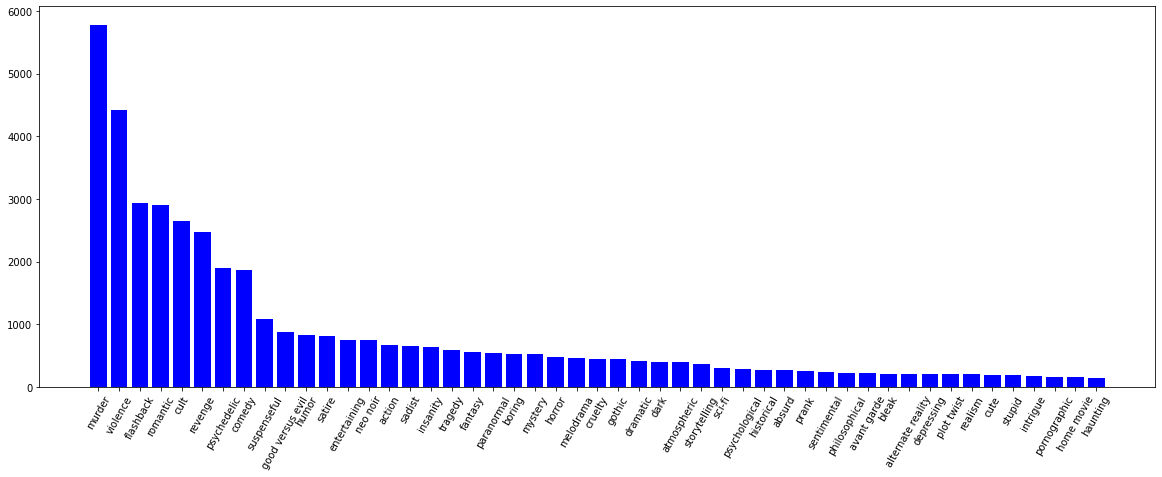

In [ ]:
# plot histogram of tags to get a sense of the data
import matplotlib.pyplot as plt

dict_tags_freq = { i : 0 for i in tags_list }

for index, row in movie_data.iterrows():
    text=row['tags'].split(',') 
    for i in range(len(text)):
        if text[i][0]==' ':
            text[i]=text[i][1:]
        dict_tags_freq[text[i]]+=1

dict_tags_most_frequent=dict()
for key in dict_tags_freq.keys():
  
    if dict_tags_freq[key]/len(movie_data) >0.01:
        dict_tags_most_frequent[key]=dict_tags_freq[key]*-1 # adding a minus sign just for ordering

freq, keys = (list(t) for t in zip(*sorted(zip(dict_tags_most_frequent.values(),list(dict_tags_most_frequent.keys())))))
freq = list(-t for t in freq) # turning to positive again for ploting
print(list(zip(keys,freq)))

fig=plt.figure(figsize=(20,7))
ax = fig.add_subplot(1,1,1)
plt.bar(keys, freq, color='b',)
ax.set_xticklabels(keys, rotation=60)
plt.show()

In [ ]:
# https://data-dive.com/finetune-german-gpt2-on-tpu-transformers-tensorflow-for-text-generation-of-reviews
# https://towardsdatascience.com/natural-language-generation-part-2-gpt-2-and-huggingface-f3acb35bc86a

BOS_TOKEN = '<|startoftext|>'
EOS_TOKEN = '<|endoftext|>'
PAD_TOKEN = '<|pad|>' 

tags_tokens=dict()
for i in tags_list:
    tags_tokens[i]='<|'+i+'|>'

In [ ]:
# Choose transformers model and create tokenizer 

# Create model using transformers
import transformers as transformers
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf

model_config=transformers.PretrainedConfig.from_pretrained(transformer_model_name)
tokenizer = AutoTokenizer.from_pretrained(transformer_model_name,
                                          pad_token=PAD_TOKEN)

# Add tokens to tokenizer
tokenizer.add_tokens(BOS_TOKEN, special_tokens=True)

category_token_ids=list()

for token in tags_tokens.values():
    tokenizer.add_tokens(token,special_tokens=True)
    category_token_ids.append(tokenizer.get_vocab()[token])

print(model_config)

In [ ]:
# Create inputs and outputs for training
movie_data['plot_extended']=''
for index, row in movie_data.iterrows():
    
    tags = row['tags'].split(',')
    beginning_string=''

    for item in tags:
        if item[0]==' ':
          item=item[1:]
        beginning_string+=tags_tokens[item]

    row['plot_extended']=beginning_string + BOS_TOKEN + row['plot_synopsis']

movie_data.head()

,title,plot_synopsis,tags,synopsis_source,plot_extended
0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",imdb,<|cult|><|horror|><|gothic|><|murder|><|atmosp...
1,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,imdb,<|violence|><|startoftext|>Two thousand years ...
2,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,imdb,"<|romantic|><|startoftext|>Matuschek's, a gift..."
3,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",imdb,<|inspiring|><|romantic|><|stupid|><|feel-good...
4,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",imdb,<|cruelty|><|murder|><|dramatic|><|cult|><|vio...


In [ ]:
# https://data-dive.com/finetune-german-gpt2-on-tpu-transformers-tensorflow-for-text-generation-of-reviews

# Convert our movie data to hugginface dataset
movie_data_ds = Dataset.from_pandas(movie_data)

In [ ]:
%%time

output = {}

count=0
def tokenize_function(examples, tokenizer=tokenizer,max_length=1024):

    mx_l=max_length+1 # we already added BOS_TOKEN, so we add +1 to the max_length
    # Add start and end token to each comment
    examples = [ex + '<|endoftext|>' for ex in examples["plot_extended"]]
    # tokenizer created input_ids and attention_mask as output
    output = tokenizer(
        examples,
        add_special_tokens=True,  # Only adds pad not eos and bos
        max_length=mx_l,
        truncation=True,
        padding=True
        # pad_to_max_length=True,
    )

    dot_id=tokenizer.get_vocab()['.']
    eos_id=tokenizer.get_vocab()[EOS_TOKEN]
    pad_id=tokenizer.get_vocab()[PAD_TOKEN]

    for ind in range(len(output['input_ids'])):
        input_id=output['input_ids'][ind]
        
        # if our plot is bigger than 1024, we need to trim it
        was_truncated=(output['input_ids'][ind][-1]!=pad_id)

        # If string was truncated, we should find and pad until the last dot pontuaction '.' and add eos_id
        # if not, than we should find last not pad_id and add eos_id right affter it
        for i in range(len(input_id)-1,0,-1):
            if was_truncated:
                if input_id[i]==dot_id and i+1!=mx_l:
                    output['input_ids'][ind][i+1]=eos_id
                    output['attention_mask'][ind][i+1]=1
                    break
                else:
                    output['input_ids'][ind][i]=pad_id
                    output['attention_mask'][ind][i]=0
            else:
                if input_id[i]!=pad_id:
                    output['input_ids'][ind][i+1]=eos_id
                    output['attention_mask'][ind][i+1]=1
                    break

    # shift labels for next token prediction
    # set padding and category token labels to -100 which is ignored in loss computation
    output["labels"] = [x[1:] for x in output["input_ids"]]

    output["labels"] = [
        # [-100 if (x == tokenizer.pad_token_id) else x for x in y]
        [-100 if (x == tokenizer.pad_token_id or (x in category_token_ids)) else x for x in y]
        for y in output["labels"]
    ]
    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output

movie_data_ds = movie_data_ds.map(
    tokenize_function,
    batched=True,
    remove_columns=["plot_synopsis","title","tags","synopsis_source"],
    num_proc=strategy.num_replicas_in_sync,
)

print(movie_data_ds)

Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'plot_extended'],
    num_rows: 14828
})
CPU times: user 7.18 s, sys: 2.82 s, total: 10 s
Wall time: 38.9 s


In [ ]:
movie_data_ds = movie_data_ds.train_test_split(
    test_size=0.1, shuffle=True, seed=1, load_from_cache_file=True
)
print(movie_data_ds)

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'plot_extended'],
        num_rows: 13345
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'plot_extended'],
        num_rows: 1483
    })
})


In [ ]:
%%time
# prepare for use in tensorflow
train_tensor_inputs = tf.convert_to_tensor(movie_data_ds["train"]["input_ids"])
train_tensor_labels = tf.convert_to_tensor(movie_data_ds["train"]["labels"])
train_tensor_mask = tf.convert_to_tensor(movie_data_ds["train"]["attention_mask"])
train = tf.data.Dataset.from_tensor_slices(
    (
        {"input_ids": train_tensor_inputs, "attention_mask": train_tensor_mask},
        train_tensor_labels,
    )
)

test_tensor_inputs = tf.convert_to_tensor(movie_data_ds["test"]["input_ids"])
test_tensor_labels = tf.convert_to_tensor(movie_data_ds["test"]["labels"])
test_tensor_mask = tf.convert_to_tensor(movie_data_ds["test"]["attention_mask"])
test = tf.data.Dataset.from_tensor_slices(
    (
        {"input_ids": test_tensor_inputs, "attention_mask": test_tensor_mask},
        test_tensor_labels,
    )
)

CPU times: user 30.3 s, sys: 825 ms, total: 31.1 s
Wall time: 30.6 s


In [ ]:
from transformers import TFGPT2LMHeadModel

optimizer = tf.keras.optimizers.Adam(learning_rate=6.25e-5)

with strategy.scope():
    if not continue_previous_training:
        model = TFGPT2LMHeadModel.from_pretrained(transformer_model_name,
                use_cache=False,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,)
        model.resize_token_embeddings(len(tokenizer))

        model.compile(optimizer=optimizer, loss=model.compute_loss,run_eagerly=False)
        
        model.summary()
    else:
        model = TFGPT2LMHeadModel.from_pretrained('/content/gdrive/My Drive/Colab Files/models/'+transformer_model_name)
        model.compile(optimizer=optimizer, loss=model.compute_loss,run_eagerly=False)

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-medium.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 354897920 
 r)                                                              
                                                                 
Total params: 354,897,920
Trainable params: 354,897,920
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if tpu:
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
else:
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA

BUFFER_SIZE = len(train)

# prepare data for consumption
train_ds = (
    train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
)
test_ds = test.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# Create callbacks

class SaveTransformersModelCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if save_model:
            model.save_pretrained('/content/gdrive/My Drive/Colab Files/models/'+transformer_model_name)

append_csv = True if not continue_previous_training else False
callbacks = [
    SaveTransformersModelCallback(),
    tf.keras.callbacks.CSVLogger('/content/gdrive/My Drive/Colab Files/models/'+transformer_model_name+'.csv',append=append_csv)
]

In [ ]:
%%time

history = model.fit(
    train_ds,
    validation_data=test_ds,
    batch_size=BATCH_SIZE,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/40
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


   6/1668 [..............................] - ETA: 9:55 - loss: 22.6952WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0066s vs `on_train_batch_end` time: 13.4874s). Check your callbacks.


1668/1668 [==============================] - 774s 393ms/step - loss: 3.2159 - val_loss: 2.9775
Epoch 2/40
1668/1668 [==============================] - 634s 380ms/step - loss: 2.9886 - val_loss: 2.9447
Epoch 3/40
1668/1668 [==============================] - 633s 380ms/step - loss: 2.8988 - val_loss: 2.9276
Epoch 4/40
1668/1668 [==============================] - 637s 382ms/step - loss: 2.8045 - val_loss: 2.9195
Epoch 5/40
1668/1668 [==============================] - 638s 383ms/step - loss: 2.7032 - val_loss: 2.9219
Epoch 6/40
1668/1668 [==============================] - 639s 383ms/step - loss: 2.5967 - val_loss: 2.9454
Epoch 7/40
1668/1668 [==============================] - 634s 380ms/step - loss: 2.4893 - val_loss: 2.9211
Epoch 8/40
1668/1668 [==============================] - 631s 378ms/step - loss: 2.3842 - val_loss: 2.9634
Epoch 9/40
1668/1668 [==============================] - 632s 379ms/step - loss: 2.2840 - val_loss: 3.0056
Epoch 10/40
1668/1668 [==============================] - 

In [ ]:
tags_tokens.values()

dict_values(['<|absurd|>', '<|action|>', '<|adult comedy|>', '<|allegory|>', '<|alternate history|>', '<|alternate reality|>', '<|anti war|>', '<|atmospheric|>', '<|autobiographical|>', '<|avant garde|>', '<|blaxploitation|>', '<|bleak|>', '<|boring|>', '<|brainwashing|>', '<|christian film|>', '<|claustrophobic|>', '<|clever|>', '<|comedy|>', '<|comic|>', '<|cruelty|>', '<|cult|>', '<|cute|>', '<|dark|>', '<|depressing|>', '<|dramatic|>', '<|entertaining|>', '<|fantasy|>', '<|feel-good|>', '<|flashback|>', '<|good versus evil|>', '<|gothic|>', '<|grindhouse film|>', '<|haunting|>', '<|historical|>', '<|historical fiction|>', '<|home movie|>', '<|horror|>', '<|humor|>', '<|insanity|>', '<|inspiring|>', '<|intrigue|>', '<|magical realism|>', '<|melodrama|>', '<|murder|>', '<|mystery|>', '<|neo noir|>', '<|non fiction|>', '<|paranormal|>', '<|philosophical|>', '<|plot twist|>', '<|pornographic|>', '<|prank|>', '<|psychedelic|>', '<|psychological|>', '<|queer|>', '<|realism|>', '<|revenge

In [ ]:
from transformers import pipeline

plot = pipeline("text-generation",model=model,tokenizer=tokenizer,)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [ ]:
genres="<|paranormal|><|paranormal|><|paranormal|><|paranormal|>"
initial_plot="A group of friends"
text=genres+'<|startoftext|>'+initial_plot
length_of_text=len(tokenizer(text)['input_ids'])
gen_plot = plot(text, max_length=length_of_text+150, num_return_sequences=3)
gen_plot_df=pd.DataFrame(gen_plot)
print('Initial plot:',initial_plot)
gen_plot_df.head()

Initial plot: A group of friends


,generated_text
0,"<|paranormal|><|paranormal|><|paranormal|><|paranormal|><|startoftext|>A group of friends, Amy (Paula Patton), Rob (Sam Ball), Tessa (Rachel Miner), Matt (Lee Majdoub), Lily (Kathryn Morris), Spencer (Emilie Ullerup), Dan (Nicole Travolta) and Spencer's sister Chloe (Taissa Farmiga), go to a cabin in the Blue Mountains in New Zealand. Amy and Spencer enter and set up a small bonfire in an attempt to pass the time until a storm strikes, during which the group become acquainted with a local named James (Ewan McGregor).\nMeanwhile, James continues to explain New Zealand's supernatural history to the group whilst drinking from a flask left by a deceased witch. After taking his flask, he's transported to the Christchurch"
1,"<|paranormal|><|paranormal|><|paranormal|><|paranormal|><|startoftext|>A group of friends, Christian, David, Kate, Sara, Johnny, Nicole, Brian, Blake, and Eric are together as a Christian couple. However, they have not had sex in months, and are concerned over how Matthew, an obsessive Christian, will react to beginning a sexual relationship with another woman. During a family trip to the beach, Christian and David discover a girl's body that was half eaten by a sea lion. Later that night they are attacked while getting a drink at the bar, David cuts his hand with a knife, but is miraculously able to talk the barman into giving him anesthetic. Christian is later sent out to the forest to recuperate, but when he returns he finds that the girl's body is missing. Christian is"
2,"<|paranormal|><|paranormal|><|paranormal|><|paranormal|><|startoftext|>A group of friends are visiting a remote laboratory, performing a procedure on Shakma, a baboon. When they notice that the ""Sumatran Rat-Monkey"" is missing, they realize it must be the missing Rat-Monkey. When climbing up the elevator they fall and break their neck, killing them. Journeying into the basement to find Rat-Monkey, they come across the scientist Dr. Abigail Craven, who performs the autopsy on the dead friends. After taking a drink of what appears to be alcohol, she is murdered by a shadowy figure.\nAfter speaking to the professor at the university about Dr. Craven's murder, Jim Hawkins, a reporter, is hired to investigate the killings and find any video footage"


In [ ]:
genres="<|fantasy|><|fantasy|><|fantasy|><|fantasy|>"
initial_plot="A group of friends"
text=genres+'<|startoftext|>'+initial_plot
length_of_text=len(tokenizer(text)['input_ids'])
gen_plot = plot(text, max_length=length_of_text+150, num_return_sequences=3)
gen_plot_df=pd.DataFrame(gen_plot)
print('Initial plot:',initial_plot)
gen_plot_df.head()

Initial plot: A group of friends


,generated_text
0,"<|fantasy|><|fantasy|><|fantasy|><|fantasy|><|startoftext|>A group of friends (Andy, Roger, Ingrid and Andy's girlfriend Lotte) travel to a holiday spot in Nantucket. The friends find themselves in a cemetery with a strange stone casket, the apparent resting place of a U.S. senator, Jacob Reamer. When Andy, an award-winning scientist, visits the cemetery and encounters Reamer's gravestone, he is sent to the past via a vision in the form of a ghost (Roger) who warns him not to go into the cemetery.\nHaving returned to the present, Andy begins experiencing nightmares that become nightmares of his own doing, caused by the presence of Reamer, who begins to tempt Andy. Reamer hypnotizes Andy, revealing he is in his body after all and"
1,"<|fantasy|><|fantasy|><|fantasy|><|fantasy|><|startoftext|>A group of friends – now adults – are traveling across Europe. Among them are Liesel, a middle-aged spinster (Mary Tyler Moore), her fiancé Axel (Gérard Depardieu), a young violinist from Kassel (Martin Schrage), and Sébastien (Jonathan Pryce), an ambitious young man from Pologne (Michael Ensign). They are joined by Ilsa (Isabelle Huppert), a cheerful Gypsy girl who desires to join the Resistance. Ilsa is taken with Axel, but her mother forbids her to touch him. As Ilsa and Axel seek refuge at the home of a Resistance fighter, Hans (Peter Stormare), they find a young girl there named Gemma (L"
2,"<|fantasy|><|fantasy|><|fantasy|><|fantasy|><|startoftext|>A group of friends and Irena (Gemma Jones) are going to a cottage for the summer to holiday. At the cottage they find a strange abandoned man staring at them from a rocking chair. The friends look back, and it turns out that the man (Pablo Adán's brother) was watching them. He attacks Irena before letting go, and kills her. The others go. They discover the body.Next morning, Lara (Emmy Rossum) and Rafael (Gael Garcia Bernal) wake up to find Jason (René Auberjonois) is dead and that his neck has been broken via castration. Meanwhile, Sheriff Hammond (Jim Cummings) determines that it was not a murder, and wants to question everyone"


In [ ]:
genres="<|murder|><|murder|><|murder|><|murder|>"
initial_plot="A group of friends"
text=genres+'<|startoftext|>'+initial_plot
length_of_text=len(tokenizer(text)['input_ids'])
gen_plot = plot(text, max_length=length_of_text+150, num_return_sequences=3)
gen_plot_df=pd.DataFrame(gen_plot)
print('Initial plot:',initial_plot)
gen_plot_df.head()

Initial plot: A group of friends


,generated_text
0,"<|murder|><|murder|><|murder|><|murder|><|startoftext|>A group of friends are having dinner and reminiscing. George Dumont (Jack Lemmon) is recounting how many women have walked his beautiful wife Lillian (Carolyn Jones). George recalls how they tried to keep her together and that she is tired, bitter, depressed and never satisfied. This inspires the others to make a plan to try to get the woman out of their lives.We see Lillian and a gang of thugs break her in. The thuggers tie her to a chair and set her on a table with a solitary box of matches. Lillian sits calmly as the other thugs search the house for the match. They leave her tied up to the chair with the box of matches and set her on a table with just a solitary candle. An unknown"
1,"<|murder|><|murder|><|murder|><|murder|><|startoftext|>A group of friends share a few drinks, when an eminent doctor, Wolfe Macfarlane, enters. One of the friends, Fettes, recognizes the name and angrily confronts the new arrival. Although his friends all find this behaviour suspicious, none of them can understand what might lie behind it.\nIt transpires that Macfarlane and Fettes had attended medical school together, under the famous professor of anatomy, Robert Knox. Their duties included taking receipt of bodies for dissection, and paying the pair of shifty and suspicious men who supplied them.\nOn one occasion, Fettes identifies a body as that of a woman he knew, and is convinced she has been murdered. But Macfarlane talks him out of reporting the incident, lest they are both implicated"
2,"<|murder|><|murder|><|murder|><|murder|><|startoftext|>A group of friends are having a party at the beach with some of their classmates. Terry (Eriq Ebouaney), Moai (Alyy Khan), Lena (Zoë Saldaña), Jin (Francis Rolfe), Ok (Victor Rasuk), and Richard (Justin Bartha) all attend. Richard is teaching Clarissa (Alison Folland) to surf and he has a crush on her. When Terry turns up, she realizes he is infatuated not only with her, but also with Moai. Despite Terry's best attempts to hide it, Moai is aggressively pursuing him, pressuring and overly excited in response to his touches. She becomes frustrated when his friends and family do not understand why he is"


In [ ]:
genres="<|romantic|><|romantic|><|romantic|><|romantic|>"
initial_plot="A group of friends"
text=genres+'<|startoftext|>'+initial_plot
length_of_text=len(tokenizer(text)['input_ids'])
gen_plot = plot(text, max_length=length_of_text+150, num_return_sequences=3)
gen_plot_df=pd.DataFrame(gen_plot)
print('Initial plot:',initial_plot)
gen_plot_df.head()

Initial plot: A group of friends


,generated_text
0,"<|romantic|><|romantic|><|romantic|><|romantic|><|startoftext|>A group of friends are having a party at the beach with a clown. As one of them gets his coat, his girlfriend tells him it is time they go inside, but is persuaded by her father to change their plans when he sees she has rather expensive shoes to wear.\nOn their way inside having decided to purchase the shoes, the clown has an argument with his girlfriend's father. This leads to the pair starting arguing just outside the front door. Upon arriving at the house, the father mistakes them for burglars and calls the police, who arrive just in time to save them.\nThe pair hide out in the house's garden whilst the father is out. When he returns, the pair reveal he has been tricked; the pair have only rented the house and"
1,"<|romantic|><|romantic|><|romantic|><|romantic|><|startoftext|>A group of friends, Amy (Susan May Pratt), Ben (Zachary Bennett), Lauren (Sarah Hayden), Reed (Christine Taylor), Dan (Texas Battle), and Ian (Greyston Holt), decide to pledge a sorority. After a poor performance at a previous sorority rush, Amy convinces the rest of the girls to do the same; this is an unusual sorority pledge, as they are not allowed to pledge anything outside their sorority. Amy takes Dan and Ian, the awkward, nerdy guys from her class, and convinces them that they need a reason to pursue a social life together, so they will stick together for a while.\nThe three ladies grow closer over the course of the film, though each girl's reason for committing"
2,"<|romantic|><|romantic|><|romantic|><|romantic|><|startoftext|>A group of friends consisting of Zoe (Rebecca Sugar), Adam (Alan Rickman), Marlee (Justin Long), Nate (Freddie Highmore), Jasmine (Erin Daniels), and Richard (Shawn Mitchell) decide to pledge a sorority. The night of the initiation, Marlee and Richard choose the four pledges: Bailey (Riley Keough), Cheyenne (Vanessa Hudgens), Tessa (Vanessa Hudgens), and Devon (Antonia Stout). Bailey and Cheyenne originally leave the group in search for a date and are unable to complete the initiation. They, in spite of this, decide to forgo their original intentions and become pledges.\nThe next morning, Marlee and Richard leave to complete their task"


In [ ]:
genres="<|comedy|><|comedy|><|comedy|><|comedy|>"
initial_plot="A group of friends"
text=genres+'<|startoftext|>'+initial_plot
length_of_text=len(tokenizer(text)['input_ids'])
gen_plot = plot(text, max_length=length_of_text+150, num_return_sequences=3)
gen_plot_df=pd.DataFrame(gen_plot)
print('Initial plot:',initial_plot)
gen_plot_df.head()

Initial plot: A group of friends


,generated_text
0,"<|comedy|><|comedy|><|comedy|><|comedy|><|startoftext|>A group of friends are having a party at their rural Louisiana house one night. During dinner, the host reveals that he has hired a crew to bring in the local wildlife to be killed for a petting zoo. It seems the group had not previously known about the fact that one of the men, Richard ""Ricky"" Anderson, is a professional speaker who moonlights as a rather verbose and pretentious southern do-gooder with a long history of helping animals.\nThe others take this opportunity to indulge in dog-whistle and make small talk — with the exception of Rollo, who tries to repair his failing automobile. Much of the conversation is then devoted to Ricky's various pranks and the misdeeds of his amateur animal rights activism, which"
1,"<|comedy|><|comedy|><|comedy|><|comedy|><|startoftext|>A group of friends across the country—Dave (Craig Benjamin), Paul (Rider Strong), Barry (Danny McBride), Nan (Michelle Bauer), Steven (Jason Barry), Bill (Clark Johnson), Max (Lou Gossett Jr.), and Ron (Barry Bostwick) —gather to celebrate the holidays. Dave and Paul are a married couple with a young son. Paul's wife is having an affair with Bev (Betsy Russell), and she desires children. The group agree to have the party for cheap, so they can party without having to worry about falling in love with each other's spouses. Max (Seth Green), Nan, Steven, Max's wife, and Bernie (Jon Lovitz) break the rules, despite being married—"
2,"<|comedy|><|comedy|><|comedy|><|comedy|><|startoftext|>A group of friends – Mark, Roger, Terry, David and Sara – take an annual trip across Britain. They have a diverse mixture of political views and personalities: the jolly good-natured Mark meets the sexy and cosmopolitan Sara, the cynical and lovable Roger enjoys the company of glamorous and lovable Nigel, the middle-aged David brings his beautiful wife Sue home from her job at an insurance firm, and the talkative Terry enjoys the company of attractive and lively Karin, Sara's colleague.\nEncouraged by their caper in Crete, the four get drunk at a wild seaside carnival as an excuse to take photographs, but the incident leaves them even more lovable and political. They visit a series of holiday accommodation at the top"
